# Deep Support Vector Data Description with Data Structure Preservation using Autoencoders in Pytorch

## Imports

In [1]:
# This packages should be used with lower versions because of incompatibility issues
!pip install "click>=7,<8"

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 82.8/82.8 kB 2.4 MB/s eta 0:00:00
  Attempting uninstall: click
    Found existing installation: click 8.1.7
    Uninstalling click-8.1.7:
      Successfully uninstalled click-8.1.7
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
flask 2.2.5 requires click>=8.0, but you have click 7.1.2 which is incompatible.
dask 2023.8.1 requires click>=8.0, but you have click 7.1.2 which is incompatible.
distributed 2023.8.1 requires click>=8.0, but you have click 7.1.2 which is incompatible.
fiona 1.9.6 requires click~=8.0, but you have click 7.1.2 which is incompatible.
pip-tools 6.13.0 requires click>=8, but you have click 7.1.2 which is incompatible.


In [2]:
# Base Python Imports
import json
import time
import click
import random
import logging
from abc import ABC, abstractmethod

# Library Imports
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
from sklearn.metrics import roc_auc_score
from torchvision.utils import make_grid
from tqdm.notebook import tqdm, trange

import torch
import torch.optim as optim
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, Subset
from torchvision.datasets import CIFAR10, MNIST
import torchvision.transforms as transforms

## `base` folder

In [3]:
import logging
import numpy as np
import torch.nn as nn
from torch.utils.data import DataLoader
from abc import ABC, abstractmethod

### Contents of `base_dataset.py`

In [4]:
class BaseADDataset(ABC):
    """Anomaly detection dataset base class."""

    def __init__(self, root: str):
        super().__init__()
        self.root = root  # root path to data

        self.n_classes = 2  # 0: normal, 1: outlier
        self.normal_classes = None  # tuple with original class labels that define the normal class
        self.outlier_classes = None  # tuple with original class labels that define the outlier class

        self.train_set = None  # must be of type torch.utils.data.Dataset
        self.test_set = None  # must be of type torch.utils.data.Dataset

    @abstractmethod
    def loaders(self, batch_size: int, shuffle_train=True, shuffle_test=False, num_workers: int = 0) -> (
            DataLoader, DataLoader):
        """Implement data loaders of type torch.utils.data.DataLoader for train_set and test_set."""
        pass

    def __repr__(self):
        return self.__class__.__name__

### Contents of `base_net.py`

In [5]:
class BaseNet(nn.Module):
    """Base class for all neural networks."""

    def __init__(self):
        super().__init__()
        self.logger = logging.getLogger(self.__class__.__name__)
        self.rep_dim = None  # representation dimensionality, i.e. dim of the last layer

    def forward(self, *input):
        """
        Forward pass logic
        :return: Network output
        """
        raise NotImplementedError

    def summary(self):
        """Network summary."""
        net_parameters = filter(lambda p: p.requires_grad, self.parameters())
        params = sum([np.prod(p.size()) for p in net_parameters])
        self.logger.info('Trainable parameters: {}'.format(params))
        self.logger.info(self)

### Contents of `base_trainer.py`

In [6]:
class BaseTrainer(ABC):
    """Trainer base class."""

    def __init__(self,
                 optimizer_name: str,
                 lr: float,
                 n_epochs: int,
                 lr_milestones: tuple,
                 batch_size: int,
                 weight_decay: float,
                 device: str,
                 n_jobs_dataloader: int):
        super().__init__()
        self.optimizer_name = optimizer_name
        self.lr = lr
        self.n_epochs = n_epochs
        self.lr_milestones = lr_milestones
        self.batch_size = batch_size
        self.weight_decay = weight_decay
        self.device = device
        self.n_jobs_dataloader = n_jobs_dataloader

    @abstractmethod
    def train(self, dataset: BaseADDataset, net: BaseNet) -> BaseNet:
        """
        Implement train method that trains the given network using the train_set of dataset.
        :return: Trained net
        """
        pass

    @abstractmethod
    def test(self, dataset: BaseADDataset, net: BaseNet):
        """
        Implement test method that evaluates the test_set of dataset on the given network.
        """
        pass

### Contents of `torchvision_dataset.py`

In [7]:
class TorchvisionDataset(BaseADDataset):
    """TorchvisionDataset class for datasets already implemented in torchvision.datasets."""

    def __init__(self, root: str):
        super().__init__(root)

    def loaders(self, batch_size: int, shuffle_train=True, shuffle_test=False, num_workers: int = 0) -> (
            DataLoader, DataLoader):
        train_loader = DataLoader(
            dataset=self.train_set,
            batch_size=batch_size,
            shuffle=shuffle_train,
            num_workers=num_workers
        )
        test_loader = DataLoader(
            dataset=self.test_set,
            batch_size=batch_size,
            shuffle=shuffle_test,
            num_workers=num_workers
        )
        return train_loader, test_loader

## `utils` folder

### Contents of `config.py`

In [8]:
class Config(object):
    """Base class for experimental setting/configuration."""

    def __init__(self, settings):
        self.settings = settings

    def load_config(self, import_json):
        """Load settings dict from import_json (path/filename.json) JSON-file."""

        with open(import_json, 'r') as fp:
            settings = json.load(fp)

        for key, value in settings.items():
            self.settings[key] = value

    def save_config(self, export_json):
        """Save settings dict to export_json (path/filename.json) JSON-file."""

        with open(export_json, 'w') as fp:
            json.dump(self.settings, fp)

### Contents of `plot.py`

In [9]:
def plot_images_grid(x: torch.tensor, export_img, title: str = '', nrow=8, padding=2, normalize=False, pad_value=0):
    """Plot 4D Tensor of images of shape (B x C x H x W) as a grid."""

    grid = make_grid(x, nrow=nrow, padding=padding, normalize=normalize, pad_value=pad_value)
    npgrid = grid.cpu().numpy()

    plt.imshow(np.transpose(npgrid, (1, 2, 0)), interpolation='nearest')

    ax = plt.gca()
    ax.xaxis.set_visible(False)
    ax.yaxis.set_visible(False)

    if not (title == ''):
        plt.title(title)

    plt.savefig(export_img, bbox_inches='tight', pad_inches=0.1)

## `datasets` folder

### Contents of `cifar10.py`

In [10]:
class CIFAR10_Dataset(TorchvisionDataset):

    def __init__(self, root: str, normal_class=5):
        super().__init__(root)

        self.n_classes = 2  # 0: normal, 1: outlier
        self.normal_classes = tuple([normal_class])
        self.outlier_classes = list(range(0, 10))
        self.outlier_classes.remove(normal_class)

        # Pre-computed min and max values (after applying GCN) from train data per class
        min_max = [(-28.94083453598571, 13.802961825439636),
                   (-6.681770233365245, 9.158067708230273),
                   (-34.924463588638204, 14.419298165027628),
                   (-10.599172931391799, 11.093187820377565),
                   (-11.945022995801637, 10.628045447867583),
                   (-9.691969487694928, 8.948326776180823),
                   (-9.174940012342555, 13.847014686472365),
                   (-6.876682005899029, 12.282371383343161),
                   (-15.603507135507172, 15.2464923804279),
                   (-6.132882973622672, 8.046098172351265)]

        # CIFAR-10 preprocessing: GCN (with L1 norm) and min-max feature scaling to [0,1]
        transform = transforms.Compose([transforms.ToTensor(),
                                        transforms.Lambda(lambda x: global_contrast_normalization(x, scale='l1')),
                                        transforms.Normalize([min_max[normal_class][0]] * 3,
                                                             [min_max[normal_class][1] - min_max[normal_class][0]] * 3)])

        target_transform = transforms.Lambda(lambda x: int(x in self.outlier_classes))

        train_set = MyCIFAR10(root=self.root, train=True, download=True,
                              transform=transform, target_transform=target_transform)
        # Subset train set to normal class
        train_idx_normal = get_target_label_idx(train_set.train_labels, self.normal_classes)
        self.train_set = Subset(train_set, train_idx_normal)

        self.test_set = MyCIFAR10(root=self.root, train=False, download=True,
                                  transform=transform, target_transform=target_transform)


class MyCIFAR10(CIFAR10):
    """Torchvision CIFAR10 class with patch of __getitem__ method to also return the index of a data sample."""

    def __init__(self, *args, **kwargs):
        super(MyCIFAR10, self).__init__(*args, **kwargs)

    def __getitem__(self, index):
        """Override the original method of the CIFAR10 class.
        Args:
            index (int): Index
        Returns:
            triple: (image, target, index) where target is index of the target class.
        """
        if self.train:
            img, target = self.train_data[index], self.train_labels[index]
        else:
            img, target = self.test_data[index], self.test_labels[index]

        # doing this so that it is consistent with all other datasets
        # to return a PIL Image
        img = Image.fromarray(img)

        if self.transform is not None:
            img = self.transform(img)

        if self.target_transform is not None:
            target = self.target_transform(target)

        return img, target, index  # only line changed

### Contents of `mnist.py`

In [11]:
class MNIST_Dataset(TorchvisionDataset):

    def __init__(self, root: str, normal_class=0):
        super().__init__(root)

        self.n_classes = 2  # 0: normal, 1: outlier
        self.normal_classes = tuple([normal_class])
        self.outlier_classes = list(range(0, 10))
        self.outlier_classes.remove(normal_class)

        # Pre-computed min and max values (after applying GCN) from train data per class
        min_max = [(-0.8826567065619495, 9.001545489292527),
                   (-0.6661464580883915, 20.108062262467364),
                   (-0.7820454743183202, 11.665100841080346),
                   (-0.7645772083211267, 12.895051191467457),
                   (-0.7253923114302238, 12.683235701611533),
                   (-0.7698501867861425, 13.103278415430502),
                   (-0.778418217980696, 10.457837397569108),
                   (-0.7129780970522351, 12.057777597673047),
                   (-0.8280402650205075, 10.581538445782988),
                   (-0.7369959242164307, 10.697039838804978)]

        # MNIST preprocessing: GCN (with L1 norm) and min-max feature scaling to [0,1]
        transform = transforms.Compose([transforms.ToTensor(),
                                        transforms.Lambda(lambda x: global_contrast_normalization(x, scale='l1')),
                                        transforms.Normalize([min_max[normal_class][0]],
                                                             [min_max[normal_class][1] - min_max[normal_class][0]])])

        target_transform = transforms.Lambda(lambda x: int(x in self.outlier_classes))

        train_set = MyMNIST(root=self.root, train=True, download=True,
                            transform=transform, target_transform=target_transform)
        # Subset train_set to normal class
        train_idx_normal = get_target_label_idx(train_set.train_labels.clone().data.cpu().numpy(), self.normal_classes)
        self.train_set = Subset(train_set, train_idx_normal)

        self.test_set = MyMNIST(root=self.root, train=False, download=True,
                                transform=transform, target_transform=target_transform)


class MyMNIST(MNIST):
    """Torchvision MNIST class with patch of __getitem__ method to also return the index of a data sample."""

    def __init__(self, *args, **kwargs):
        super(MyMNIST, self).__init__(*args, **kwargs)

    def __getitem__(self, index):
        """Override the original method of the MNIST class.
        Args:
            index (int): Index
        Returns:
            triple: (image, target, index) where target is index of the target class.
        """
        if self.train:
            img, target = self.train_data[index], self.train_labels[index]
        else:
            img, target = self.test_data[index], self.test_labels[index]

        # doing this so that it is consistent with all other datasets
        # to return a PIL Image
        img = Image.fromarray(img.numpy(), mode='L')

        if self.transform is not None:
            img = self.transform(img)

        if self.target_transform is not None:
            target = self.target_transform(target)

        return img, target, index  # only line changed

### Contents of `preprocessing.py`

In [12]:
def get_target_label_idx(labels, targets):
    """
    Get the indices of labels that are included in targets.
    :param labels: array of labels
    :param targets: list/tuple of target labels
    :return: list with indices of target labels
    """
    return np.argwhere(np.isin(labels, targets)).flatten().tolist()


def global_contrast_normalization(x: torch.tensor, scale='l2'):
    """
    Apply global contrast normalization to tensor, i.e. subtract mean across features (pixels) and normalize by scale,
    which is either the standard deviation, L1- or L2-norm across features (pixels).
    Note this is a *per sample* normalization globally across features (and not across the dataset).
    """

    assert scale in ('l1', 'l2')

    n_features = int(np.prod(x.shape))

    mean = torch.mean(x)  # mean over all features (pixels) per sample
    x -= mean

    if scale == 'l1':
        x_scale = torch.mean(torch.abs(x))

    if scale == 'l2':
        x_scale = torch.sqrt(torch.sum(x ** 2)) / n_features

    x /= x_scale

    return x

### Contents of `main.py`

In [13]:
def load_dataset(dataset_name, data_path, normal_class):
    """Loads the dataset."""

    implemented_datasets = ('mnist', 'cifar10')
    assert dataset_name in implemented_datasets

    dataset = None

    if dataset_name == 'mnist':
        dataset = MNIST_Dataset(root=data_path, normal_class=normal_class)

    if dataset_name == 'cifar10':
        dataset = CIFAR10_Dataset(root=data_path, normal_class=normal_class)

    return dataset

## `networks` folder

### Contents of `cifar10_LeNet_elu.py`

In [14]:
class CIFAR10_LeNet_ELU(BaseNet):

    def __init__(self):
        super().__init__()

        self.rep_dim = 128
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)

        self.conv1 = nn.Conv2d(in_channels=3, out_channels=32, kernel_size=5, bias=False, padding=2)
        self.bn2d1 = nn.BatchNorm2d(num_features=32, eps=1e-04, affine=False)
        self.conv2 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=5, bias=False, padding=2)
        self.bn2d2 = nn.BatchNorm2d(num_features=64, eps=1e-04, affine=False)
        self.conv3 = nn.Conv2d(in_channels=64, out_channels=128, kernel_size=5, bias=False, padding=2)
        self.bn2d3 = nn.BatchNorm2d(num_features=128, eps=1e-04, affine=False)
        self.fc1 = nn.Linear(in_features=128 * 4 * 4, out_features=self.rep_dim, bias=False)

    def forward(self, x):
        x = self.conv1(x)
        x = self.pool(F.elu(self.bn2d1(x)))
        x = self.conv2(x)
        x = self.pool(F.elu(self.bn2d2(x)))
        x = self.conv3(x)
        x = self.pool(F.elu(self.bn2d3(x)))
        x = x.view(x.size(0), -1)
        x = self.fc1(x)
        return x


class CIFAR10_LeNet_ELU_Autoencoder(BaseNet):

    def __init__(self):
        super().__init__()

        self.rep_dim = 128
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)

        # Encoder (must match the Deep SVDD network above)
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=32, kernel_size=5, bias=False, padding=2)
        nn.init.xavier_uniform_(self.conv1.weight)
        self.bn2d1 = nn.BatchNorm2d(num_features=32, eps=1e-04, affine=False)
        self.conv2 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=5, bias=False, padding=2)
        nn.init.xavier_uniform_(self.conv2.weight)
        self.bn2d2 = nn.BatchNorm2d(num_features=64, eps=1e-04, affine=False)
        self.conv3 = nn.Conv2d(in_channels=64, out_channels=128, kernel_size=5, bias=False, padding=2)
        nn.init.xavier_uniform_(self.conv3.weight)
        self.bn2d3 = nn.BatchNorm2d(num_features=128, eps=1e-04, affine=False)
        self.fc1 = nn.Linear(in_features=128 * 4 * 4, out_features=self.rep_dim, bias=False)
        self.bn1d = nn.BatchNorm1d(num_features=self.rep_dim, eps=1e-04, affine=False)

        # Decoder
        self.deconv1 = nn.ConvTranspose2d(in_channels=int(self.rep_dim / (4 * 4)), out_channels=128, kernel_size=5, bias=False, padding=2)
        nn.init.xavier_uniform_(self.deconv1.weight)
        self.bn2d4 = nn.BatchNorm2d(num_features=128, eps=1e-04, affine=False)
        self.deconv2 = nn.ConvTranspose2d(in_channels=128, out_channels=64, kernel_size=5, bias=False, padding=2)
        nn.init.xavier_uniform_(self.deconv2.weight)
        self.bn2d5 = nn.BatchNorm2d(num_features=64, eps=1e-04, affine=False)
        self.deconv3 = nn.ConvTranspose2d(in_channels=64, out_channels=32, kernel_size=5, bias=False, padding=2)
        nn.init.xavier_uniform_(self.deconv3.weight)
        self.bn2d6 = nn.BatchNorm2d(num_features=32, eps=1e-04, affine=False)
        self.deconv4 = nn.ConvTranspose2d(in_channels=32, out_channels=3, kernel_size=5, bias=False, padding=2)
        nn.init.xavier_uniform_(self.deconv4.weight)

    def forward(self, x):
        x = self.conv1(x)
        x = self.pool(F.elu(self.bn2d1(x)))
        x = self.conv2(x)
        x = self.pool(F.elu(self.bn2d2(x)))
        x = self.conv3(x)
        x = self.pool(F.elu(self.bn2d3(x)))
        x = x.view(x.size(0), -1)
        x = self.bn1d(self.fc1(x))
        x = x.view(x.size(0), int(self.rep_dim / (4 * 4)), 4, 4)
        x = F.elu(x)
        x = self.deconv1(x)
        x = F.interpolate(F.elu(self.bn2d4(x)), scale_factor=2)
        x = self.deconv2(x)
        x = F.interpolate(F.elu(self.bn2d5(x)), scale_factor=2)
        x = self.deconv3(x)
        x = F.interpolate(F.elu(self.bn2d6(x)), scale_factor=2)
        x = self.deconv4(x)
        x = torch.sigmoid(x)
        return x

### Contents of `cifar10_LeNet.py`

In [15]:
class CIFAR10_LeNet(BaseNet):

    def __init__(self):
        super().__init__()

        self.rep_dim = 128
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)

        self.conv1 = nn.Conv2d(in_channels=3, out_channels=32, kernel_size=5, bias=False, padding=2)
        self.bn2d1 = nn.BatchNorm2d(num_features=32, eps=1e-04, affine=False)
        self.conv2 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=5, bias=False, padding=2)
        self.bn2d2 = nn.BatchNorm2d(num_features=64, eps=1e-04, affine=False)
        self.conv3 = nn.Conv2d(in_channels=64, out_channels=128, kernel_size=5, bias=False, padding=2)
        self.bn2d3 = nn.BatchNorm2d(num_features=128, eps=1e-04, affine=False)
        self.fc1 = nn.Linear(in_features=128 * 4 * 4, out_features=self.rep_dim, bias=False)

    def forward(self, x):
        x = self.conv1(x)
        x = self.pool(F.leaky_relu(self.bn2d1(x)))
        x = self.conv2(x)
        x = self.pool(F.leaky_relu(self.bn2d2(x)))
        x = self.conv3(x)
        x = self.pool(F.leaky_relu(self.bn2d3(x)))
        x = x.view(x.size(0), -1)
        x = self.fc1(x)
        return x


class CIFAR10_LeNet_Autoencoder(BaseNet):

    def __init__(self):
        super().__init__()

        self.rep_dim = 128
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)

        # Encoder (must match the Deep SVDD network above)
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=32, kernel_size=5, bias=False, padding=2)
        nn.init.xavier_uniform_(self.conv1.weight, gain=nn.init.calculate_gain('leaky_relu'))
        self.bn2d1 = nn.BatchNorm2d(num_features=32, eps=1e-04, affine=False)
        self.conv2 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=5, bias=False, padding=2)
        nn.init.xavier_uniform_(self.conv2.weight, gain=nn.init.calculate_gain('leaky_relu'))
        self.bn2d2 = nn.BatchNorm2d(num_features=64, eps=1e-04, affine=False)
        self.conv3 = nn.Conv2d(in_channels=64, out_channels=128, kernel_size=5, bias=False, padding=2)
        nn.init.xavier_uniform_(self.conv3.weight, gain=nn.init.calculate_gain('leaky_relu'))
        self.bn2d3 = nn.BatchNorm2d(num_features=128, eps=1e-04, affine=False)
        self.fc1 = nn.Linear(in_features=128 * 4 * 4, out_features=self.rep_dim, bias=False)
        self.bn1d = nn.BatchNorm1d(num_features=self.rep_dim, eps=1e-04, affine=False)

        # Decoder
        self.deconv1 = nn.ConvTranspose2d(in_channels=int(self.rep_dim / (4 * 4)), out_channels=128, kernel_size=5, bias=False, padding=2)
        nn.init.xavier_uniform_(self.deconv1.weight, gain=nn.init.calculate_gain('leaky_relu'))
        self.bn2d4 = nn.BatchNorm2d(num_features=128, eps=1e-04, affine=False)
        self.deconv2 = nn.ConvTranspose2d(in_channels=128, out_channels=64, kernel_size=5, bias=False, padding=2)
        nn.init.xavier_uniform_(self.deconv2.weight, gain=nn.init.calculate_gain('leaky_relu'))
        self.bn2d5 = nn.BatchNorm2d(num_features=64, eps=1e-04, affine=False)
        self.deconv3 = nn.ConvTranspose2d(in_channels=64, out_channels=32, kernel_size=5, bias=False, padding=2)
        nn.init.xavier_uniform_(self.deconv3.weight, gain=nn.init.calculate_gain('leaky_relu'))
        self.bn2d6 = nn.BatchNorm2d(num_features=32, eps=1e-04, affine=False)
        self.deconv4 = nn.ConvTranspose2d(in_channels=32, out_channels=3, kernel_size=5, bias=False, padding=2)
        nn.init.xavier_uniform_(self.deconv4.weight, gain=nn.init.calculate_gain('leaky_relu'))

    def forward(self, x):
        x = self.conv1(x)
        x = self.pool(F.leaky_relu(self.bn2d1(x)))
        x = self.conv2(x)
        x = self.pool(F.leaky_relu(self.bn2d2(x)))
        x = self.conv3(x)
        x = self.pool(F.leaky_relu(self.bn2d3(x)))
        x = x.view(x.size(0), -1)
        x = self.bn1d(self.fc1(x))
        x = x.view(x.size(0), int(self.rep_dim / (4 * 4)), 4, 4)
        x = F.leaky_relu(x)
        x = self.deconv1(x)
        x = F.interpolate(F.leaky_relu(self.bn2d4(x)), scale_factor=2)
        x = self.deconv2(x)
        x = F.interpolate(F.leaky_relu(self.bn2d5(x)), scale_factor=2)
        x = self.deconv3(x)
        x = F.interpolate(F.leaky_relu(self.bn2d6(x)), scale_factor=2)
        x = self.deconv4(x)
        x = torch.sigmoid(x)
        return x

### Contents of `mnist_LeNet.py`

In [16]:
class MNIST_LeNet_Encoder(BaseNet):
    def __init__(self, rep_dim=32):
        super().__init__()

        self.rep_dim = rep_dim
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)

        self.conv1 = nn.Conv2d(in_channels=1, out_channels=8, kernel_size=5, bias=False, padding=2)
        self.bn1 = nn.BatchNorm2d(num_features=8, eps=1e-04, affine=False)
        self.conv2 = nn.Conv2d(in_channels=8, out_channels=4, kernel_size=5, bias=False, padding=2)
        self.bn2 = nn.BatchNorm2d(num_features=4, eps=1e-04, affine=False)
        self.fc1 = nn.Linear(in_features=4 * 7 * 7, out_features=self.rep_dim, bias=False)

    def forward(self, x):
        x = self.conv1(x)
        x = self.pool(F.leaky_relu(self.bn1(x)))
        x = self.conv2(x)
        x = self.pool(F.leaky_relu(self.bn2(x)))
        x = x.view(x.size(0), -1)
        x = self.fc1(x)
        return x

class MNIST_LeNet_Decoder(BaseNet):
    def __init__(self, rep_dim=32):
        super().__init__()

        self.rep_dim = rep_dim

        self.deconv1 = nn.ConvTranspose2d(in_channels=2, out_channels=4, kernel_size=5, bias=False, padding=2)
        self.bn3 = nn.BatchNorm2d(num_features=4, eps=1e-04, affine=False)
        self.deconv2 = nn.ConvTranspose2d(in_channels=4, out_channels=8, kernel_size=5, bias=False, padding=3)
        self.bn4 = nn.BatchNorm2d(num_features=8, eps=1e-04, affine=False)
        self.deconv3 = nn.ConvTranspose2d(in_channels=8, out_channels=1, kernel_size=5, bias=False, padding=2)

    def forward(self, x):
        x = x.view(x.size(0), int(self.rep_dim / 16), 4, 4)
        x = F.interpolate(F.leaky_relu(x), scale_factor=2)
        x = self.deconv1(x)
        x = F.interpolate(F.leaky_relu(self.bn3(x)), scale_factor=2)
        x = self.deconv2(x)
        x = F.interpolate(F.leaky_relu(self.bn4(x)), scale_factor=2)
        x = self.deconv3(x)
        x = torch.sigmoid(x)
        return x


class MNIST_LeNet_Autoencoder(BaseNet):
    def __init__(self, rep_dim=32):
        super().__init__()

        self.rep_dim = rep_dim
        self.encoder = MNIST_LeNet_Encoder(rep_dim)
        self.decoder = MNIST_LeNet_Decoder(rep_dim)

    def forward(self, x, return_latent=False):
        latent_features = self.encoder(x)
        decoded = self.decoder(latent_features)

        if return_latent:
          return decoded, latent_features
        return decoded

### Contents of `main.py`

In [17]:
def build_network(net_name):
    """Builds the neural network."""

    implemented_networks = ('mnist_LeNet', 'cifar10_LeNet', 'cifar10_LeNet_ELU')
    assert net_name in implemented_networks

    net = None

    if net_name == 'mnist_LeNet':
        net = MNIST_LeNet_Autoencoder()

    if net_name == 'cifar10_LeNet':
        net = CIFAR10_LeNet()

    if net_name == 'cifar10_LeNet_ELU':
        net = CIFAR10_LeNet_ELU()

    return net


def build_autoencoder(net_name):
    """Builds the corresponding autoencoder network."""

    implemented_networks = ('mnist_LeNet', 'cifar10_LeNet', 'cifar10_LeNet_ELU')
    assert net_name in implemented_networks

    ae_net = None

    if net_name == 'mnist_LeNet':
        ae_net = MNIST_LeNet_Autoencoder()

    if net_name == 'cifar10_LeNet':
        ae_net = CIFAR10_LeNet_Autoencoder()

    if net_name == 'cifar10_LeNet_ELU':
        ae_net = CIFAR10_LeNet_ELU_Autoencoder()

    return ae_net

## `optim` folder

In [18]:
def MSELoss(x, x_hat):
    """
    Computes the mean squared error loss for inputs and outputs
    """
    scores = torch.sum((x_hat - x) ** 2, dim=tuple(range(1, x_hat.dim())))
    loss = torch.mean(scores)
    return loss

### Contents of `ae_trainer.py`

In [47]:
class AETrainer(BaseTrainer):

    def __init__(self,
                 optimizer_name: str = 'adam',
                 lr: float = 0.001,
                 n_epochs: int = 150,
                 lr_milestones: tuple = (),
                 batch_size: int = 128,
                 weight_decay: float = 1e-6,
                 device: str = 'cuda',
                 n_jobs_dataloader: int = 0):
        super().__init__(optimizer_name, lr, n_epochs, lr_milestones, batch_size, weight_decay, device,
                         n_jobs_dataloader)

    def objective(self, x, x_hat):
        loss = MSELoss(x, x_hat)
        return loss

    def test_score(self, x, x_hat):
        scores = torch.sum((outputs - inputs) ** 2, dim=tuple(range(1, outputs.dim())))
        return scores

    def train(self, dataset: BaseADDataset, ae_net: BaseNet):
        logger = logging.getLogger()

        # Set device for network
        ae_net = ae_net.to(self.device)

        # Get train data loader
        train_loader, _ = dataset.loaders(batch_size=self.batch_size, num_workers=self.n_jobs_dataloader)

        # Set optimizer (Adam optimizer for now)
        optimizer = optim.Adam(ae_net.parameters(), lr=self.lr, weight_decay=self.weight_decay,
                               amsgrad=self.optimizer_name == 'amsgrad')

        # Set learning rate scheduler
        scheduler = optim.lr_scheduler.MultiStepLR(optimizer, milestones=self.lr_milestones, gamma=0.1)

        # Training
        logger.info('Starting pretraining...')
        start_time = time.time()
        ae_net.train()
        for epoch in trange(self.n_epochs, desc="Epoch"):

            scheduler.step()
            if epoch in self.lr_milestones:
                logger.info('  LR scheduler: new learning rate is %g' % float(scheduler.get_lr()[0]))

            loss_epoch = 0.0
            n_batches = 0
            epoch_start_time = time.time()
            for data in tqdm(train_loader):
                inputs, _, _ = data
                inputs = inputs.to(self.device)

                # Zero the network parameter gradients
                optimizer.zero_grad()

                # Update network parameters via backpropagation: forward + backward + optimize
                # For autoencoder we are using MSE Loss
                # TODO: Try with nn.MSELoss()
                outputs = ae_net(inputs)
                loss = self.objective(inputs, outputs)
                loss.backward()
                optimizer.step()

                loss_epoch += loss.item()
                n_batches += 1

            # log epoch statistics
            epoch_train_time = time.time() - epoch_start_time
            logger.info('  Epoch {}/{}\t Time: {:.3f}\t Loss: {:.8f}'
                        .format(epoch + 1, self.n_epochs, epoch_train_time, loss_epoch / n_batches))

        pretrain_time = time.time() - start_time
        logger.info('Pretraining time: %.3f' % pretrain_time)
        logger.info('Finished pretraining.')

        return ae_net

    def test(self, dataset: BaseADDataset, ae_net: BaseNet):
        logger = logging.getLogger()

        # Set device for network
        ae_net = ae_net.to(self.device)

        # Get test data loader
        _, test_loader = dataset.loaders(batch_size=self.batch_size, num_workers=self.n_jobs_dataloader)

        # Testing
        logger.info('Testing autoencoder...')
        loss_epoch = 0.0
        n_batches = 0
        start_time = time.time()
        idx_label_score = []
        ae_net.eval()
        with torch.no_grad():
            for data in tqdm(test_loader):
                inputs, labels, idx = data
                inputs = inputs.to(self.device)
                outputs = ae_net(inputs)
                scores = self.test_scores(inputs, outputs)
                loss = torch.mean(scores)

                # Save triple of (idx, label, score) in a list
                idx_label_score += list(zip(idx.cpu().data.numpy().tolist(),
                                            labels.cpu().data.numpy().tolist(),
                                            scores.cpu().data.numpy().tolist()))

                loss_epoch += loss.item()
                n_batches += 1

        logger.info('Test set Loss: {:.8f}'.format(loss_epoch / n_batches))

        _, labels, scores = zip(*idx_label_score)
        labels = np.array(labels)
        scores = np.array(scores)

        auc = roc_auc_score(labels, scores)
        logger.info('Test set AUC: {:.2f}%'.format(100. * auc))

        test_time = time.time() - start_time
        logger.info('Autoencoder testing time: %.3f' % test_time)
        logger.info('Finished testing autoencoder.')

### Contents of `deepSVDD_trainer.py`

In [44]:
class DeepSVDDTrainer(BaseTrainer):
    def __init__(self,
                 R,
                 c,
                 gamma: float = 0.1,
                 optimizer_name: str = 'adam',
                 lr: float = 0.001,
                 n_epochs: int = 150,
                 lr_milestones: tuple = (),
                 batch_size: int = 128,
                 weight_decay: float = 1e-6,
                 device: str = 'cuda',
                 n_jobs_dataloader: int = 0):
        super().__init__(optimizer_name, lr, n_epochs, lr_milestones, batch_size, weight_decay, device,
                         n_jobs_dataloader)

        # Deep SVDD parameters
        self.R = torch.tensor(R, device=self.device)  # radius R initialized with 0 by default.
        self.c = torch.tensor(c, device=self.device) if c is not None else None
        self.gamma = gamma

        # Results
        self.train_time = None
        self.test_auc = None
        self.test_time = None
        self.test_scores = None

    def objective(self, x, x_hat, latent_features):
        distances = torch.sum((latent_features - self.c) ** 2, dim=1)
        ae_mse = MSELoss(x, x_hat)
        loss = torch.mean(distances) + self.gamma * ae_mse
        return loss

    def test_score(self, x, latent_features):
        score = torch.sum((latent_features - self.c) ** 2, dim=1)
        return score

    def train(self, dataset: BaseADDataset, net: BaseNet):
        logger = logging.getLogger()

        # Set device for network
        net = net.to(self.device)

        # Get train data loader
        train_loader, _ = dataset.loaders(batch_size=self.batch_size, num_workers=self.n_jobs_dataloader)

        # Set optimizer (Adam optimizer for now)
        optimizer = optim.Adam(net.parameters(), lr=self.lr, weight_decay=self.weight_decay,
                               amsgrad=self.optimizer_name == 'amsgrad')

        # Set learning rate scheduler
        scheduler = optim.lr_scheduler.MultiStepLR(optimizer, milestones=self.lr_milestones, gamma=0.1)

        # Initialize hypersphere center c (if c not loaded)
        if self.c is None:
            logger.info('Initializing center c...')
            self.c = self.init_center_c(train_loader, net)
            logger.info('Center c initialized.')

        # Training
        logger.info('Starting training...')
        start_time = time.time()
        net.train()
        for epoch in trange(self.n_epochs, desc="Epoch"):
            scheduler.step()
            if epoch in self.lr_milestones:
                logger.info('  LR scheduler: new learning rate is %g' % float(scheduler.get_lr()[0]))

            loss_epoch = 0.0
            n_batches = 0
            epoch_start_time = time.time()
            for data in tqdm(train_loader):
                inputs, _, _ = data
                inputs = inputs.to(self.device)

                # Zero the network parameter gradients
                optimizer.zero_grad()

                # Update network parameters via backpropagation: forward + backward + optimize
                decoder_outputs, latent_features = net(inputs, return_latent=True)
                loss = self.objective(inputs, decoder_outputs, latent_features)
                loss.backward()
                optimizer.step()

                loss_epoch += loss.item()
                n_batches += 1

            # log epoch statistics
            epoch_train_time = time.time() - epoch_start_time
            logger.info('  Epoch {}/{}\t Time: {:.3f}\t Loss: {:.8f}'
                        .format(epoch + 1, self.n_epochs, epoch_train_time, loss_epoch / n_batches))

        self.train_time = time.time() - start_time
        logger.info('Training time: %.3f' % self.train_time)

        logger.info('Finished training.')

        return net

    def test(self, dataset: BaseADDataset, net: BaseNet):
        logger = logging.getLogger()

        # Set device for network
        net = net.to(self.device)

        # Get test data loader
        _, test_loader = dataset.loaders(batch_size=self.batch_size, num_workers=self.n_jobs_dataloader)

        # Testing
        logger.info('Starting testing...')
        start_time = time.time()
        idx_label_score = []
        net.eval()
        with torch.no_grad():
            for data in tqdm(test_loader):
                inputs, labels, idx = data
                inputs = inputs.to(self.device)
                _, latent_features = net(inputs, return_latent=True)
                scores = self.test_score(inputs, latent_features)
                # if self.objective == 'soft-boundary':
                #     scores = dist - self.R ** 2
                # else:
                #     scores = dist

                # Save triples of (idx, label, score) in a list
                idx_label_score += list(zip(idx.cpu().data.numpy().tolist(),
                                            labels.cpu().data.numpy().tolist(),
                                            scores.cpu().data.numpy().tolist()))

        self.test_time = time.time() - start_time
        logger.info('Testing time: %.3f' % self.test_time)

        self.test_scores = idx_label_score

        # Compute AUC
        _, labels, scores = zip(*idx_label_score)
        labels = np.array(labels)
        scores = np.array(scores)

        self.test_auc = roc_auc_score(labels, scores)
        logger.info('Test set AUC: {:.2f}%'.format(100. * self.test_auc))

        logger.info('Finished testing.')

    def init_center_c(self, train_loader: DataLoader, net: BaseNet, eps=0.1):
        """Initialize hypersphere center c as the mean from an initial forward pass on the data."""
        n_samples = 0
        c = torch.zeros(net.rep_dim, device=self.device)

        net.eval()
        with torch.no_grad():
            for data in tqdm(train_loader):
                # get the inputs of the batch
                inputs, _, _ = data
                inputs = inputs.to(self.device)
                _, outputs = net(inputs, return_latent=True)
                n_samples += outputs.shape[0]
                c += torch.sum(outputs, dim=0)

        c /= n_samples

        # If c_i is too close to 0, set to +-eps. Reason: a zero unit can be trivially matched with zero weights.
        c[(abs(c) < eps) & (c < 0)] = -eps
        c[(abs(c) < eps) & (c > 0)] = eps

        return c


def get_radius(dist: torch.Tensor, nu: float):
    """Optimally solve for radius R via the (1-nu)-quantile of distances."""
    return np.quantile(np.sqrt(dist.clone().data.cpu().numpy()), 1 - nu)

## Main content

### Contents of `deepSVDD.py` (Deep SVDD Model)


In [32]:
class DeepSVDD(object):
    """A class for the Deep SVDD method.

    Attributes:
        objective: A string specifying the Deep SVDD objective (either 'one-class' or 'soft-boundary').
        nu: Deep SVDD hyperparameter nu (must be 0 < nu <= 1).
        R: Hypersphere radius R.
        c: Hypersphere center c.
        net_name: A string indicating the name of the neural network to use.
        net: The neural network \phi.
        ae_net: The autoencoder network corresponding to \phi for network weights pretraining.
        trainer: DeepSVDDTrainer to train a Deep SVDD model.
        optimizer_name: A string indicating the optimizer to use for training the Deep SVDD network.
        ae_trainer: AETrainer to train an autoencoder in pretraining.
        ae_optimizer_name: A string indicating the optimizer to use for pretraining the autoencoder.
        results: A dictionary to save the results.
    """

    def __init__(self, gamma: float = 0.1):
        """Inits DeepSVDD with one of the two objectives and hyperparameter nu."""

        # assert (0 < nu) & (nu <= 1), "For hyperparameter nu, it must hold: 0 < nu <= 1."
        # self.nu = nu
        self.gamma = gamma
        self.R = 0.0  # hypersphere radius R
        self.c = None  # hypersphere center c

        self.net_name = None
        self.net = None  # neural network \phi

        self.trainer = None
        self.optimizer_name = None

        self.ae_net = None  # autoencoder network for pretraining
        self.ae_trainer = None
        self.ae_optimizer_name = None

        self.results = {
            'train_time': None,
            'test_auc': None,
            'test_time': None,
            'test_scores': None,
        }
        print("Deep SVDD initialized")

    def set_network(self, net_name):
        """Builds the neural network \phi."""
        self.net_name = net_name
        self.net = build_network(net_name)

    def train(self,
              dataset: BaseADDataset,
              optimizer_name: str = 'adam',
              lr: float = 0.001,
              n_epochs: int = 50,
              lr_milestones: tuple = (),
              batch_size: int = 128,
              weight_decay: float = 1e-6,
              device: str = 'cuda',
              n_jobs_dataloader: int = 0):
        """Trains the Deep SVDD model on the training data."""

        self.optimizer_name = optimizer_name
        self.trainer = DeepSVDDTrainer(self.R, self.c, self.gamma, optimizer_name, lr=lr,
                                       n_epochs=n_epochs, lr_milestones=lr_milestones, batch_size=batch_size,
                                       weight_decay=weight_decay, device=device, n_jobs_dataloader=n_jobs_dataloader)
        print("DeepSVDDTrainer initialized")
        # Get the model
        self.net = self.trainer.train(dataset, self.net)
        self.R = float(self.trainer.R.cpu().data.numpy())  # get float
        self.c = self.trainer.c.cpu().data.numpy().tolist()  # get list
        self.results['train_time'] = self.trainer.train_time

    def test(self, dataset: BaseADDataset, device: str = 'cuda', n_jobs_dataloader: int = 0):
        """Tests the Deep SVDD model on the test data."""

        if self.trainer is None:
            self.trainer = DeepSVDDTrainer(self.objective, self.R, self.c, self.nu,
                                           device=device, n_jobs_dataloader=n_jobs_dataloader)

        self.trainer.test(dataset, self.net)
        # Get results
        self.results['test_auc'] = self.trainer.test_auc
        self.results['test_time'] = self.trainer.test_time
        self.results['test_scores'] = self.trainer.test_scores

    def pretrain(self,
                 dataset: BaseADDataset,
                 optimizer_name: str = 'adam',
                 lr: float = 0.001,
                 n_epochs: int = 100,
                 lr_milestones: tuple = (),
                 batch_size: int = 128,
                 weight_decay: float = 1e-6,
                 device: str = 'cuda',
                 n_jobs_dataloader: int = 0):
        """Pretrains the weights for the Deep SVDD network \phi via autoencoder."""

        self.ae_net = build_autoencoder(self.net_name)
        self.ae_optimizer_name = optimizer_name
        self.ae_trainer = AETrainer(optimizer_name, lr=lr, n_epochs=n_epochs, lr_milestones=lr_milestones,
                                    batch_size=batch_size, weight_decay=weight_decay, device=device,
                                    n_jobs_dataloader=n_jobs_dataloader)
        self.ae_net = self.ae_trainer.train(dataset, self.ae_net)
        self.ae_trainer.test(dataset, self.ae_net)
        self.init_network_weights_from_pretraining()

    def init_network_weights_from_pretraining(self):
        """Initialize the Deep SVDD network weights from the encoder weights of the pretraining autoencoder."""

        net_dict = self.net.state_dict()
        ae_net_dict = self.ae_net.state_dict()

        # Filter out decoder network keys
        ae_net_dict = {k: v for k, v in ae_net_dict.items() if k in net_dict}
        # Overwrite values in the existing state_dict
        net_dict.update(ae_net_dict)
        # Load the new state_dict
        self.net.load_state_dict(net_dict)

    def save_model(self, export_model, save_ae=True):
        """Save Deep SVDD model to export_model."""

        net_dict = self.net.state_dict()
        ae_net_dict = self.ae_net.state_dict() if save_ae else None

        torch.save({'R': self.R,
                    'c': self.c,
                    'net_dict': net_dict,
                    'ae_net_dict': ae_net_dict}, export_model)

    def load_model(self, model_path, load_ae=False):
        """Load Deep SVDD model from model_path."""

        model_dict = torch.load(model_path)

        self.R = model_dict['R']
        self.c = model_dict['c']
        self.net.load_state_dict(model_dict['net_dict'])
        if load_ae:
            if self.ae_net is None:
                self.ae_net = build_autoencoder(self.net_name)
            self.ae_net.load_state_dict(model_dict['ae_net_dict'])

    def save_results(self, export_json):
        """Save results dict to a JSON-file."""
        with open(export_json, 'w') as fp:
            json.dump(self.results, fp)


### Contents of `main.py`

In [20]:
################################################################################
# Settings
################################################################################
@click.command()
@click.argument('dataset_name', type=click.Choice(['mnist', 'cifar10']))
@click.argument('net_name', type=click.Choice(['mnist_LeNet', 'cifar10_LeNet', 'cifar10_LeNet_ELU']))
@click.argument('xp_path', type=click.Path(exists=True))
@click.argument('data_path', type=click.Path(exists=True))
@click.option('--load_config', type=click.Path(exists=True), default=None,
              help='Config JSON-file path (default: None).')
@click.option('--load_model', type=click.Path(exists=True), default=None,
              help='Model file path (default: None).')
@click.option('--objective', type=click.Choice(['one-class', 'soft-boundary']), default='one-class',
              help='Specify Deep SVDD objective ("one-class" or "soft-boundary").')
@click.option('--nu', type=float, default=0.1, help='Deep SVDD hyperparameter nu (must be 0 < nu <= 1).')
@click.option('--device', type=str, default='cuda', help='Computation device to use ("cpu", "cuda", "cuda:2", etc.).')
@click.option('--seed', type=int, default=-1, help='Set seed. If -1, use randomization.')
@click.option('--optimizer_name', type=click.Choice(['adam', 'amsgrad']), default='adam',
              help='Name of the optimizer to use for Deep SVDD network training.')
@click.option('--lr', type=float, default=0.001,
              help='Initial learning rate for Deep SVDD network training. Default=0.001')
@click.option('--n_epochs', type=int, default=50, help='Number of epochs to train.')
@click.option('--lr_milestone', type=int, default=0, multiple=True,
              help='Lr scheduler milestones at which lr is multiplied by 0.1. Can be multiple and must be increasing.')
@click.option('--batch_size', type=int, default=128, help='Batch size for mini-batch training.')
@click.option('--weight_decay', type=float, default=1e-6,
              help='Weight decay (L2 penalty) hyperparameter for Deep SVDD objective.')
@click.option('--pretrain', type=bool, default=True,
              help='Pretrain neural network parameters via autoencoder.')
@click.option('--ae_optimizer_name', type=click.Choice(['adam', 'amsgrad']), default='adam',
              help='Name of the optimizer to use for autoencoder pretraining.')
@click.option('--ae_lr', type=float, default=0.001,
              help='Initial learning rate for autoencoder pretraining. Default=0.001')
@click.option('--ae_n_epochs', type=int, default=100, help='Number of epochs to train autoencoder.')
@click.option('--ae_lr_milestone', type=int, default=0, multiple=True,
              help='Lr scheduler milestones at which lr is multiplied by 0.1. Can be multiple and must be increasing.')
@click.option('--ae_batch_size', type=int, default=128, help='Batch size for mini-batch autoencoder training.')
@click.option('--ae_weight_decay', type=float, default=1e-6,
              help='Weight decay (L2 penalty) hyperparameter for autoencoder objective.')
@click.option('--n_jobs_dataloader', type=int, default=0,
              help='Number of workers for data loading. 0 means that the data will be loaded in the main process.')
@click.option('--normal_class', type=int, default=0,
              help='Specify the normal class of the dataset (all other classes are considered anomalous).')
def main(dataset_name, net_name, xp_path, data_path, load_config, load_model, objective, nu, device, seed,
         optimizer_name, lr, n_epochs, lr_milestone, batch_size, weight_decay, pretrain, ae_optimizer_name, ae_lr,
         ae_n_epochs, ae_lr_milestone, ae_batch_size, ae_weight_decay, n_jobs_dataloader, normal_class):
    """
    Deep SVDD, a fully deep method for anomaly detection.

    :arg DATASET_NAME: Name of the dataset to load.
    :arg NET_NAME: Name of the neural network to use.
    :arg XP_PATH: Export path for logging the experiment.
    :arg DATA_PATH: Root path of data.
    """
    return run(dataset_name, net_name, xp_path, data_path, load_config, load_model, objective, nu, device, seed,
         optimizer_name, lr, n_epochs, lr_milestone, batch_size, weight_decay, pretrain, ae_optimizer_name, ae_lr,
         ae_n_epochs, ae_lr_milestone, ae_batch_size, ae_weight_decay, n_jobs_dataloader, normal_class)

In [40]:
def run(dataset_name,
        net_name,
        xp_path,
        data_path,
        load_config,
        load_model,
        gamma,
        device,
        seed,
        optimizer_name,
        lr,
        n_epochs,
        lr_milestone,
        batch_size,
        weight_decay,
        pretrain,
        ae_optimizer_name,
        ae_lr,
        ae_n_epochs,
        ae_lr_milestone,
        ae_batch_size,
        ae_weight_decay,
        n_jobs_dataloader,
        normal_class):
    """
    Deep SVDD, a fully deep method for anomaly detection.

    :arg DATASET_NAME: Name of the dataset to load.
    :arg NET_NAME: Name of the neural network to use.
    :arg XP_PATH: Export path for logging the experiment.
    :arg DATA_PATH: Root path of data.
    """

    # Prehandle parameters
    if type(lr_milestone) == int:
      lr_milestone = [lr_milestone]
    if type(ae_lr_milestone) == int:
      ae_lr_milestone = [ae_lr_milestone]

    # Get configuration
    cfg = Config(locals().copy())

    # Set up logging
    logging.basicConfig(level=logging.DEBUG)
    logger = logging.getLogger()
    logger.setLevel(logging.DEBUG)
    formatter = logging.Formatter('%(asctime)s - %(name)s - %(levelname)s - %(message)s')
    log_file = xp_path + '/log.txt'
    file_handler = logging.FileHandler(log_file)
    file_handler.setLevel(logging.DEBUG)
    file_handler.setFormatter(formatter)
    logger.addHandler(file_handler)

    # Print arguments
    logger.info('Log file is %s.' % log_file)
    logger.info('Data path is %s.' % data_path)
    logger.info('Export path is %s.' % xp_path)

    logger.info('Dataset: %s' % dataset_name)
    logger.info('Normal class: %d' % normal_class)
    logger.info('Network: %s' % net_name)

    # If specified, load experiment config from JSON-file
    if load_config:
        cfg.load_config(import_json=load_config)
        logger.info('Loaded configuration from %s.' % load_config)

    # Print configuration
    # logger.info('Deep SVDD objective: %s' % cfg.settings['objective'])
    # logger.info('Nu-paramerter: %.2f' % cfg.settings['nu'])

    # Set seed
    if cfg.settings['seed'] != -1:
        random.seed(cfg.settings['seed'])
        np.random.seed(cfg.settings['seed'])
        torch.manual_seed(cfg.settings['seed'])
        logger.info('Set seed to %d.' % cfg.settings['seed'])

    # Default device to 'cpu' if cuda is not available
    if not torch.cuda.is_available():
        device = 'cpu'
    logger.info('Computation device: %s' % device)
    logger.info('Number of dataloader workers: %d' % n_jobs_dataloader)

    # Load data
    dataset = load_dataset(dataset_name, data_path, normal_class)

    # Initialize DeepSVDD model and set neural network \phi
    deep_SVDD = DeepSVDD(cfg.settings['gamma'])
    deep_SVDD.set_network(net_name)
    # If specified, load Deep SVDD model (radius R, center c, network weights, and possibly autoencoder weights)
    if load_model:
        deep_SVDD.load_model(model_path=load_model, load_ae=True)
        logger.info('Loading model from %s.' % load_model)

    logger.info('Pretraining: %s' % pretrain)
    if pretrain:
        # Log pretraining details
        logger.info('Pretraining optimizer: %s' % cfg.settings['ae_optimizer_name'])
        logger.info('Pretraining learning rate: %g' % cfg.settings['ae_lr'])
        logger.info('Pretraining epochs: %d' % cfg.settings['ae_n_epochs'])
        logger.info('Pretraining learning rate scheduler milestones: %s' % (cfg.settings['ae_lr_milestone'],))
        logger.info('Pretraining batch size: %d' % cfg.settings['ae_batch_size'])
        logger.info('Pretraining weight decay: %g' % cfg.settings['ae_weight_decay'])

        # Pretrain model on dataset (via autoencoder)
        deep_SVDD.pretrain(dataset,
                           optimizer_name=cfg.settings['ae_optimizer_name'],
                           lr=cfg.settings['ae_lr'],
                           n_epochs=cfg.settings['ae_n_epochs'],
                           lr_milestones=cfg.settings['ae_lr_milestone'],
                           batch_size=cfg.settings['ae_batch_size'],
                           weight_decay=cfg.settings['ae_weight_decay'],
                           device=device,
                           n_jobs_dataloader=n_jobs_dataloader)

    # Log training details
    logger.info('Training optimizer: %s' % cfg.settings['optimizer_name'])
    logger.info('Training learning rate: %g' % cfg.settings['lr'])
    logger.info('Training epochs: %d' % cfg.settings['n_epochs'])
    logger.info('Training learning rate scheduler milestones: %s' % (cfg.settings['lr_milestone'],))
    logger.info('Training batch size: %d' % cfg.settings['batch_size'])
    logger.info('Training weight decay: %g' % cfg.settings['weight_decay'])

    # Train model on dataset
    logger.debug(deep_SVDD)
    deep_SVDD.train(dataset,
                    optimizer_name=cfg.settings['optimizer_name'],
                    lr=cfg.settings['lr'],
                    n_epochs=cfg.settings['n_epochs'],
                    lr_milestones=cfg.settings['lr_milestone'],
                    batch_size=cfg.settings['batch_size'],
                    weight_decay=cfg.settings['weight_decay'],
                    device=device,
                    n_jobs_dataloader=n_jobs_dataloader)

    # Test model
    deep_SVDD.test(dataset, device=device, n_jobs_dataloader=n_jobs_dataloader)

    # Plot most anomalous and most normal (within-class) test samples
    indices, labels, scores = zip(*deep_SVDD.results['test_scores'])
    indices, labels, scores = np.array(indices), np.array(labels), np.array(scores)
    idx_sorted = indices[labels == 0][np.argsort(scores[labels == 0])]  # sorted from lowest to highest anomaly score

    if dataset_name in ('mnist', 'cifar10'):

        if dataset_name == 'mnist':
            X_normals = dataset.test_set.test_data[idx_sorted[:32], ...].unsqueeze(1)
            X_outliers = dataset.test_set.test_data[idx_sorted[-32:], ...].unsqueeze(1)

        if dataset_name == 'cifar10':
            X_normals = torch.tensor(np.transpose(dataset.test_set.test_data[idx_sorted[:32], ...], (0, 3, 1, 2)))
            X_outliers = torch.tensor(np.transpose(dataset.test_set.test_data[idx_sorted[-32:], ...], (0, 3, 1, 2)))

        plot_images_grid(X_normals, export_img=xp_path + '/normals', title='Most normal examples', padding=2)
        plot_images_grid(X_outliers, export_img=xp_path + '/outliers', title='Most anomalous examples', padding=2)

    # Save results, model, and configuration
    deep_SVDD.save_results(export_json=xp_path + '/results.json')
    deep_SVDD.save_model(export_model=xp_path + '/model.tar', save_ae=pretrain)
    cfg.save_config(export_json=xp_path + '/config.json')

## Running SVDD training and results

In [25]:
!mkdir results

INFO:root:Log file is ./results/log.txt.
INFO:root:Data path is ./.
INFO:root:Export path is ./results.
INFO:root:Dataset: mnist
INFO:root:Normal class: 0
INFO:root:Network: mnist_LeNet
INFO:root:Computation device: cuda
INFO:root:Number of dataloader workers: 0
/usr/local/lib/python3.10/dist-packages/torchvision/datasets/mnist.py:65: UserWarning: train_labels has been renamed targets
  warnings.warn("train_labels has been renamed targets")
INFO:root:Pretraining: True
INFO:root:Pretraining optimizer: adam
INFO:root:Pretraining learning rate: 0.001
INFO:root:Pretraining epochs: 100
INFO:root:Pretraining learning rate scheduler milestones: [0]
INFO:root:Pretraining batch size: 32
INFO:root:Pretraining weight decay: 1e-06
INFO:root:Starting pretraining...


Deep SVDD initialized


Epoch:   0%|          | 0/100 [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/torch/optim/lr_scheduler.py:143: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  warnings.warn("Detected call of `lr_scheduler.step()` before `optimizer.step()`. "
/usr/local/lib/python3.10/dist-packages/torch/optim/lr_scheduler.py:454: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  warnings.warn("To get the last learning rate computed by the scheduler, "
INFO:root:  LR scheduler: new learning rate is 0.0001


  0%|          | 0/186 [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/torchvision/datasets/mnist.py:75: UserWarning: train_data has been renamed data
  warnings.warn("train_data has been renamed data")
INFO:root:  Epoch 1/100	 Time: 2.990	 Loss: 103.37433497


  0%|          | 0/186 [00:00<?, ?it/s]

INFO:root:  Epoch 2/100	 Time: 2.962	 Loss: 25.73613940


  0%|          | 0/186 [00:00<?, ?it/s]

INFO:root:  Epoch 3/100	 Time: 2.968	 Loss: 13.35004688


  0%|          | 0/186 [00:00<?, ?it/s]

INFO:root:  Epoch 4/100	 Time: 3.690	 Loss: 9.98146249


  0%|          | 0/186 [00:00<?, ?it/s]

INFO:root:  Epoch 5/100	 Time: 3.131	 Loss: 8.44914376


  0%|          | 0/186 [00:00<?, ?it/s]

INFO:root:  Epoch 6/100	 Time: 3.059	 Loss: 7.49664483


  0%|          | 0/186 [00:00<?, ?it/s]

INFO:root:  Epoch 7/100	 Time: 3.156	 Loss: 6.81846780


  0%|          | 0/186 [00:00<?, ?it/s]

INFO:root:  Epoch 8/100	 Time: 3.509	 Loss: 6.28905021


  0%|          | 0/186 [00:00<?, ?it/s]

INFO:root:  Epoch 9/100	 Time: 2.997	 Loss: 5.84378697


  0%|          | 0/186 [00:00<?, ?it/s]

INFO:root:  Epoch 10/100	 Time: 2.931	 Loss: 5.46370488


  0%|          | 0/186 [00:00<?, ?it/s]

INFO:root:  Epoch 11/100	 Time: 3.196	 Loss: 5.13568720


  0%|          | 0/186 [00:00<?, ?it/s]

INFO:root:  Epoch 12/100	 Time: 3.486	 Loss: 4.85353480


  0%|          | 0/186 [00:00<?, ?it/s]

INFO:root:  Epoch 13/100	 Time: 3.153	 Loss: 4.61616077


  0%|          | 0/186 [00:00<?, ?it/s]

INFO:root:  Epoch 14/100	 Time: 3.043	 Loss: 4.40025397


  0%|          | 0/186 [00:00<?, ?it/s]

INFO:root:  Epoch 15/100	 Time: 3.604	 Loss: 4.19591184


  0%|          | 0/186 [00:00<?, ?it/s]

INFO:root:  Epoch 16/100	 Time: 3.015	 Loss: 4.01469339


  0%|          | 0/186 [00:00<?, ?it/s]

INFO:root:  Epoch 17/100	 Time: 3.028	 Loss: 3.85664525


  0%|          | 0/186 [00:00<?, ?it/s]

INFO:root:  Epoch 18/100	 Time: 5.625	 Loss: 3.72112342


  0%|          | 0/186 [00:00<?, ?it/s]

INFO:root:  Epoch 19/100	 Time: 3.242	 Loss: 3.60311358


  0%|          | 0/186 [00:00<?, ?it/s]

INFO:root:  Epoch 20/100	 Time: 3.110	 Loss: 3.50527255


  0%|          | 0/186 [00:00<?, ?it/s]

INFO:root:  Epoch 21/100	 Time: 2.961	 Loss: 3.39795657


  0%|          | 0/186 [00:00<?, ?it/s]

INFO:root:  Epoch 22/100	 Time: 3.727	 Loss: 3.29944747


  0%|          | 0/186 [00:00<?, ?it/s]

INFO:root:  Epoch 23/100	 Time: 3.147	 Loss: 3.21813049


  0%|          | 0/186 [00:00<?, ?it/s]

INFO:root:  Epoch 24/100	 Time: 2.970	 Loss: 3.14531171


  0%|          | 0/186 [00:00<?, ?it/s]

INFO:root:  Epoch 25/100	 Time: 3.101	 Loss: 3.07468193


  0%|          | 0/186 [00:00<?, ?it/s]

INFO:root:  Epoch 26/100	 Time: 3.615	 Loss: 3.00256777


  0%|          | 0/186 [00:00<?, ?it/s]

INFO:root:  Epoch 27/100	 Time: 2.968	 Loss: 2.94130761


  0%|          | 0/186 [00:00<?, ?it/s]

INFO:root:  Epoch 28/100	 Time: 2.889	 Loss: 2.88680718


  0%|          | 0/186 [00:00<?, ?it/s]

INFO:root:  Epoch 29/100	 Time: 2.920	 Loss: 2.84032653


  0%|          | 0/186 [00:00<?, ?it/s]

INFO:root:  Epoch 30/100	 Time: 3.640	 Loss: 2.79072525


  0%|          | 0/186 [00:00<?, ?it/s]

INFO:root:  Epoch 31/100	 Time: 2.920	 Loss: 2.75188821


  0%|          | 0/186 [00:00<?, ?it/s]

INFO:root:  Epoch 32/100	 Time: 3.249	 Loss: 2.70388955


  0%|          | 0/186 [00:00<?, ?it/s]

INFO:root:  Epoch 33/100	 Time: 3.488	 Loss: 2.66912496


  0%|          | 0/186 [00:00<?, ?it/s]

INFO:root:  Epoch 34/100	 Time: 3.428	 Loss: 2.64042723


  0%|          | 0/186 [00:00<?, ?it/s]

INFO:root:  Epoch 35/100	 Time: 3.062	 Loss: 2.60448298


  0%|          | 0/186 [00:00<?, ?it/s]

INFO:root:  Epoch 36/100	 Time: 2.986	 Loss: 2.56744365


  0%|          | 0/186 [00:00<?, ?it/s]

INFO:root:  Epoch 37/100	 Time: 3.590	 Loss: 2.53261185


  0%|          | 0/186 [00:00<?, ?it/s]

INFO:root:  Epoch 38/100	 Time: 3.058	 Loss: 2.51223971


  0%|          | 0/186 [00:00<?, ?it/s]

INFO:root:  Epoch 39/100	 Time: 3.017	 Loss: 2.48023809


  0%|          | 0/186 [00:00<?, ?it/s]

INFO:root:  Epoch 40/100	 Time: 2.951	 Loss: 2.45583979


  0%|          | 0/186 [00:00<?, ?it/s]

INFO:root:  Epoch 41/100	 Time: 3.555	 Loss: 2.42324216


  0%|          | 0/186 [00:00<?, ?it/s]

INFO:root:  Epoch 42/100	 Time: 3.048	 Loss: 2.40303879


  0%|          | 0/186 [00:00<?, ?it/s]

INFO:root:  Epoch 43/100	 Time: 3.065	 Loss: 2.37941971


  0%|          | 0/186 [00:00<?, ?it/s]

INFO:root:  Epoch 44/100	 Time: 3.175	 Loss: 2.34685898


  0%|          | 0/186 [00:00<?, ?it/s]

INFO:root:  Epoch 45/100	 Time: 3.643	 Loss: 2.32085728


  0%|          | 0/186 [00:00<?, ?it/s]

INFO:root:  Epoch 46/100	 Time: 3.035	 Loss: 2.29916418


  0%|          | 0/186 [00:00<?, ?it/s]

INFO:root:  Epoch 47/100	 Time: 2.960	 Loss: 2.28137746


  0%|          | 0/186 [00:00<?, ?it/s]

INFO:root:  Epoch 48/100	 Time: 3.063	 Loss: 2.26344591


  0%|          | 0/186 [00:00<?, ?it/s]

INFO:root:  Epoch 49/100	 Time: 3.578	 Loss: 2.24328506


  0%|          | 0/186 [00:00<?, ?it/s]

INFO:root:  Epoch 50/100	 Time: 2.987	 Loss: 2.22906811


  0%|          | 0/186 [00:00<?, ?it/s]

INFO:root:  Epoch 51/100	 Time: 3.225	 Loss: 2.20686577


  0%|          | 0/186 [00:00<?, ?it/s]

INFO:root:  Epoch 52/100	 Time: 3.497	 Loss: 2.18591523


  0%|          | 0/186 [00:00<?, ?it/s]

INFO:root:  Epoch 53/100	 Time: 3.401	 Loss: 2.17376092


  0%|          | 0/186 [00:00<?, ?it/s]

INFO:root:  Epoch 54/100	 Time: 3.082	 Loss: 2.16036121


  0%|          | 0/186 [00:00<?, ?it/s]

INFO:root:  Epoch 55/100	 Time: 3.156	 Loss: 2.14207277


  0%|          | 0/186 [00:00<?, ?it/s]

INFO:root:  Epoch 56/100	 Time: 3.730	 Loss: 2.12367222


  0%|          | 0/186 [00:00<?, ?it/s]

INFO:root:  Epoch 57/100	 Time: 3.125	 Loss: 2.11124247


  0%|          | 0/186 [00:00<?, ?it/s]

INFO:root:  Epoch 58/100	 Time: 3.044	 Loss: 2.10233793


  0%|          | 0/186 [00:00<?, ?it/s]

INFO:root:  Epoch 59/100	 Time: 3.059	 Loss: 2.08889116


  0%|          | 0/186 [00:00<?, ?it/s]

INFO:root:  Epoch 60/100	 Time: 3.814	 Loss: 2.06664120


  0%|          | 0/186 [00:00<?, ?it/s]

INFO:root:  Epoch 61/100	 Time: 3.049	 Loss: 2.05271066


  0%|          | 0/186 [00:00<?, ?it/s]

INFO:root:  Epoch 62/100	 Time: 3.149	 Loss: 2.04678301


  0%|          | 0/186 [00:00<?, ?it/s]

INFO:root:  Epoch 63/100	 Time: 3.234	 Loss: 2.03404662


  0%|          | 0/186 [00:00<?, ?it/s]

INFO:root:  Epoch 64/100	 Time: 3.571	 Loss: 2.02076527


  0%|          | 0/186 [00:00<?, ?it/s]

INFO:root:  Epoch 65/100	 Time: 3.110	 Loss: 2.01292685


  0%|          | 0/186 [00:00<?, ?it/s]

INFO:root:  Epoch 66/100	 Time: 3.031	 Loss: 2.00317499


  0%|          | 0/186 [00:00<?, ?it/s]

INFO:root:  Epoch 67/100	 Time: 3.575	 Loss: 1.98847771


  0%|          | 0/186 [00:00<?, ?it/s]

INFO:root:  Epoch 68/100	 Time: 3.131	 Loss: 1.98014471


  0%|          | 0/186 [00:00<?, ?it/s]

INFO:root:  Epoch 69/100	 Time: 3.084	 Loss: 1.96736895


  0%|          | 0/186 [00:00<?, ?it/s]

INFO:root:  Epoch 70/100	 Time: 3.296	 Loss: 1.96042386


  0%|          | 0/186 [00:00<?, ?it/s]

INFO:root:  Epoch 71/100	 Time: 3.771	 Loss: 1.95260490


  0%|          | 0/186 [00:00<?, ?it/s]

INFO:root:  Epoch 72/100	 Time: 3.073	 Loss: 1.94602370


  0%|          | 0/186 [00:00<?, ?it/s]

INFO:root:  Epoch 73/100	 Time: 3.101	 Loss: 1.93672708


  0%|          | 0/186 [00:00<?, ?it/s]

INFO:root:  Epoch 74/100	 Time: 3.264	 Loss: 1.92538746


  0%|          | 0/186 [00:00<?, ?it/s]

INFO:root:  Epoch 75/100	 Time: 3.702	 Loss: 1.92288035


  0%|          | 0/186 [00:00<?, ?it/s]

INFO:root:  Epoch 76/100	 Time: 3.085	 Loss: 1.91135654


  0%|          | 0/186 [00:00<?, ?it/s]

INFO:root:  Epoch 77/100	 Time: 3.079	 Loss: 1.90659070


  0%|          | 0/186 [00:00<?, ?it/s]

INFO:root:  Epoch 78/100	 Time: 3.304	 Loss: 1.89661666


  0%|          | 0/186 [00:00<?, ?it/s]

INFO:root:  Epoch 79/100	 Time: 3.621	 Loss: 1.89265854


  0%|          | 0/186 [00:00<?, ?it/s]

INFO:root:  Epoch 80/100	 Time: 3.169	 Loss: 1.88509938


  0%|          | 0/186 [00:00<?, ?it/s]

INFO:root:  Epoch 81/100	 Time: 3.030	 Loss: 1.88201736


  0%|          | 0/186 [00:00<?, ?it/s]

INFO:root:  Epoch 82/100	 Time: 3.726	 Loss: 1.87623648


  0%|          | 0/186 [00:00<?, ?it/s]

INFO:root:  Epoch 83/100	 Time: 3.088	 Loss: 1.86431620


  0%|          | 0/186 [00:00<?, ?it/s]

INFO:root:  Epoch 84/100	 Time: 3.069	 Loss: 1.85997230


  0%|          | 0/186 [00:00<?, ?it/s]

INFO:root:  Epoch 85/100	 Time: 3.129	 Loss: 1.84788525


  0%|          | 0/186 [00:00<?, ?it/s]

INFO:root:  Epoch 86/100	 Time: 3.648	 Loss: 1.84407416


  0%|          | 0/186 [00:00<?, ?it/s]

INFO:root:  Epoch 87/100	 Time: 3.081	 Loss: 1.84307734


  0%|          | 0/186 [00:00<?, ?it/s]

INFO:root:  Epoch 88/100	 Time: 3.039	 Loss: 1.83196513


  0%|          | 0/186 [00:00<?, ?it/s]

INFO:root:  Epoch 89/100	 Time: 3.335	 Loss: 1.83304392


  0%|          | 0/186 [00:00<?, ?it/s]

INFO:root:  Epoch 90/100	 Time: 3.554	 Loss: 1.82660807


  0%|          | 0/186 [00:00<?, ?it/s]

INFO:root:  Epoch 91/100	 Time: 3.081	 Loss: 1.81823392


  0%|          | 0/186 [00:00<?, ?it/s]

INFO:root:  Epoch 92/100	 Time: 2.986	 Loss: 1.81415666


  0%|          | 0/186 [00:00<?, ?it/s]

INFO:root:  Epoch 93/100	 Time: 3.473	 Loss: 1.80877854


  0%|          | 0/186 [00:00<?, ?it/s]

INFO:root:  Epoch 94/100	 Time: 3.404	 Loss: 1.81359877


  0%|          | 0/186 [00:00<?, ?it/s]

INFO:root:  Epoch 95/100	 Time: 3.055	 Loss: 1.80703189


  0%|          | 0/186 [00:00<?, ?it/s]

INFO:root:  Epoch 96/100	 Time: 3.121	 Loss: 1.80103756


  0%|          | 0/186 [00:00<?, ?it/s]

INFO:root:  Epoch 97/100	 Time: 3.653	 Loss: 1.79379991


  0%|          | 0/186 [00:00<?, ?it/s]

INFO:root:  Epoch 98/100	 Time: 3.335	 Loss: 1.79173786


  0%|          | 0/186 [00:00<?, ?it/s]

INFO:root:  Epoch 99/100	 Time: 3.141	 Loss: 1.78632335


  0%|          | 0/186 [00:00<?, ?it/s]

INFO:root:  Epoch 100/100	 Time: 3.046	 Loss: 1.78155365
INFO:root:Pretraining time: 325.903
INFO:root:Finished pretraining.
INFO:root:Testing autoencoder...


  0%|          | 0/313 [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/torchvision/datasets/mnist.py:80: UserWarning: test_data has been renamed data
  warnings.warn("test_data has been renamed data")
/usr/local/lib/python3.10/dist-packages/torchvision/datasets/mnist.py:70: UserWarning: test_labels has been renamed targets
  warnings.warn("test_labels has been renamed targets")
INFO:root:Test set Loss: 7.68281303
INFO:root:Test set AUC: 98.92%
INFO:root:Autoencoder testing time: 4.875
INFO:root:Finished testing autoencoder.
INFO:root:Training optimizer: adam
INFO:root:Training learning rate: 0.001
INFO:root:Training epochs: 50
INFO:root:Training learning rate scheduler milestones: [0]
INFO:root:Training batch size: 32
INFO:root:Training weight decay: 1e-06
DEBUG:root:<__main__.DeepSVDD object at 0x7b54e81179a0>
INFO:root:Initializing center c...


DeepSVDDTrainer initialized


  0%|          | 0/186 [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/torchvision/datasets/mnist.py:75: UserWarning: train_data has been renamed data
  warnings.warn("train_data has been renamed data")
/usr/local/lib/python3.10/dist-packages/torchvision/datasets/mnist.py:65: UserWarning: train_labels has been renamed targets
  warnings.warn("train_labels has been renamed targets")
INFO:root:Center c initialized.
INFO:root:Starting training...


Epoch:   0%|          | 0/50 [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/torch/optim/lr_scheduler.py:143: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  warnings.warn("Detected call of `lr_scheduler.step()` before `optimizer.step()`. "
/usr/local/lib/python3.10/dist-packages/torch/optim/lr_scheduler.py:454: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  warnings.warn("To get the last learning rate computed by the scheduler, "
INFO:root:  LR scheduler: new learning rate is 0.0001


  0%|          | 0/186 [00:00<?, ?it/s]

INFO:root:  Epoch 1/50	 Time: 3.164	 Loss: 2.61452382


  0%|          | 0/186 [00:00<?, ?it/s]

INFO:root:  Epoch 2/50	 Time: 3.798	 Loss: 1.09872340


  0%|          | 0/186 [00:00<?, ?it/s]

INFO:root:  Epoch 3/50	 Time: 3.080	 Loss: 0.77955746


  0%|          | 0/186 [00:00<?, ?it/s]

INFO:root:  Epoch 4/50	 Time: 3.045	 Loss: 0.64743554


  0%|          | 0/186 [00:00<?, ?it/s]

INFO:root:  Epoch 5/50	 Time: 3.328	 Loss: 0.57647506


  0%|          | 0/186 [00:00<?, ?it/s]

INFO:root:  Epoch 6/50	 Time: 3.788	 Loss: 0.52438377


  0%|          | 0/186 [00:00<?, ?it/s]

INFO:root:  Epoch 7/50	 Time: 3.137	 Loss: 0.49352179


  0%|          | 0/186 [00:00<?, ?it/s]

INFO:root:  Epoch 8/50	 Time: 3.123	 Loss: 0.47208487


  0%|          | 0/186 [00:00<?, ?it/s]

INFO:root:  Epoch 9/50	 Time: 3.219	 Loss: 0.44720233


  0%|          | 0/186 [00:00<?, ?it/s]

INFO:root:  Epoch 10/50	 Time: 3.567	 Loss: 0.43228446


  0%|          | 0/186 [00:00<?, ?it/s]

INFO:root:  Epoch 11/50	 Time: 3.115	 Loss: 0.41838799


  0%|          | 0/186 [00:00<?, ?it/s]

INFO:root:  Epoch 12/50	 Time: 3.113	 Loss: 0.40667255


  0%|          | 0/186 [00:00<?, ?it/s]

INFO:root:  Epoch 13/50	 Time: 3.506	 Loss: 0.39644888


  0%|          | 0/186 [00:00<?, ?it/s]

INFO:root:  Epoch 14/50	 Time: 3.364	 Loss: 0.38726653


  0%|          | 0/186 [00:00<?, ?it/s]

INFO:root:  Epoch 15/50	 Time: 3.267	 Loss: 0.37799360


  0%|          | 0/186 [00:00<?, ?it/s]

INFO:root:  Epoch 16/50	 Time: 3.212	 Loss: 0.37329734


  0%|          | 0/186 [00:00<?, ?it/s]

INFO:root:  Epoch 17/50	 Time: 3.782	 Loss: 0.36467813


  0%|          | 0/186 [00:00<?, ?it/s]

INFO:root:  Epoch 18/50	 Time: 3.179	 Loss: 0.35903751


  0%|          | 0/186 [00:00<?, ?it/s]

INFO:root:  Epoch 19/50	 Time: 3.171	 Loss: 0.35265676


  0%|          | 0/186 [00:00<?, ?it/s]

INFO:root:  Epoch 20/50	 Time: 3.306	 Loss: 0.34678943


  0%|          | 0/186 [00:00<?, ?it/s]

INFO:root:  Epoch 21/50	 Time: 3.530	 Loss: 0.34266038


  0%|          | 0/186 [00:00<?, ?it/s]

INFO:root:  Epoch 22/50	 Time: 3.123	 Loss: 0.34147027


  0%|          | 0/186 [00:00<?, ?it/s]

INFO:root:  Epoch 23/50	 Time: 3.359	 Loss: 0.33532955


  0%|          | 0/186 [00:00<?, ?it/s]

INFO:root:  Epoch 24/50	 Time: 3.878	 Loss: 0.33261456


  0%|          | 0/186 [00:00<?, ?it/s]

INFO:root:  Epoch 25/50	 Time: 3.128	 Loss: 0.32592839


  0%|          | 0/186 [00:00<?, ?it/s]

INFO:root:  Epoch 26/50	 Time: 3.204	 Loss: 0.32477091


  0%|          | 0/186 [00:00<?, ?it/s]

INFO:root:  Epoch 27/50	 Time: 3.192	 Loss: 0.32266459


  0%|          | 0/186 [00:00<?, ?it/s]

INFO:root:  Epoch 28/50	 Time: 3.788	 Loss: 0.31716999


  0%|          | 0/186 [00:00<?, ?it/s]

INFO:root:  Epoch 29/50	 Time: 3.130	 Loss: 0.31389521


  0%|          | 0/186 [00:00<?, ?it/s]

INFO:root:  Epoch 30/50	 Time: 3.093	 Loss: 0.31283426


  0%|          | 0/186 [00:00<?, ?it/s]

INFO:root:  Epoch 31/50	 Time: 3.457	 Loss: 0.30956785


  0%|          | 0/186 [00:00<?, ?it/s]

INFO:root:  Epoch 32/50	 Time: 3.806	 Loss: 0.30763643


  0%|          | 0/186 [00:00<?, ?it/s]

INFO:root:  Epoch 33/50	 Time: 3.178	 Loss: 0.30506961


  0%|          | 0/186 [00:00<?, ?it/s]

INFO:root:  Epoch 34/50	 Time: 3.130	 Loss: 0.30246211


  0%|          | 0/186 [00:00<?, ?it/s]

INFO:root:  Epoch 35/50	 Time: 3.819	 Loss: 0.30382897


  0%|          | 0/186 [00:00<?, ?it/s]

INFO:root:  Epoch 36/50	 Time: 3.114	 Loss: 0.29946802


  0%|          | 0/186 [00:00<?, ?it/s]

INFO:root:  Epoch 37/50	 Time: 3.183	 Loss: 0.30030077


  0%|          | 0/186 [00:00<?, ?it/s]

INFO:root:  Epoch 38/50	 Time: 3.157	 Loss: 0.29572100


  0%|          | 0/186 [00:00<?, ?it/s]

INFO:root:  Epoch 39/50	 Time: 3.874	 Loss: 0.29275830


  0%|          | 0/186 [00:00<?, ?it/s]

INFO:root:  Epoch 40/50	 Time: 3.201	 Loss: 0.29388051


  0%|          | 0/186 [00:00<?, ?it/s]

INFO:root:  Epoch 41/50	 Time: 3.403	 Loss: 0.29117311


  0%|          | 0/186 [00:00<?, ?it/s]

INFO:root:  Epoch 42/50	 Time: 3.733	 Loss: 0.28813062


  0%|          | 0/186 [00:00<?, ?it/s]

INFO:root:  Epoch 43/50	 Time: 3.271	 Loss: 0.28806900


  0%|          | 0/186 [00:00<?, ?it/s]

INFO:root:  Epoch 44/50	 Time: 3.284	 Loss: 0.28590433


  0%|          | 0/186 [00:00<?, ?it/s]

INFO:root:  Epoch 45/50	 Time: 3.197	 Loss: 0.28606206


  0%|          | 0/186 [00:00<?, ?it/s]

INFO:root:  Epoch 46/50	 Time: 3.877	 Loss: 0.28288677


  0%|          | 0/186 [00:00<?, ?it/s]

INFO:root:  Epoch 47/50	 Time: 3.156	 Loss: 0.28325997


  0%|          | 0/186 [00:00<?, ?it/s]

INFO:root:  Epoch 48/50	 Time: 3.091	 Loss: 0.28190645


  0%|          | 0/186 [00:00<?, ?it/s]

INFO:root:  Epoch 49/50	 Time: 3.341	 Loss: 0.28049541


  0%|          | 0/186 [00:00<?, ?it/s]

INFO:root:  Epoch 50/50	 Time: 3.828	 Loss: 0.28014990
INFO:root:Training time: 168.116
INFO:root:Finished training.
INFO:root:Starting testing...


  0%|          | 0/313 [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/torchvision/datasets/mnist.py:80: UserWarning: test_data has been renamed data
  warnings.warn("test_data has been renamed data")
/usr/local/lib/python3.10/dist-packages/torchvision/datasets/mnist.py:70: UserWarning: test_labels has been renamed targets
  warnings.warn("test_labels has been renamed targets")
INFO:root:Testing time: 4.237
INFO:root:Test set AUC: 97.31%
INFO:root:Finished testing.
/usr/local/lib/python3.10/dist-packages/torchvision/datasets/mnist.py:80: UserWarning: test_data has been renamed data
  warnings.warn("test_data has been renamed data")


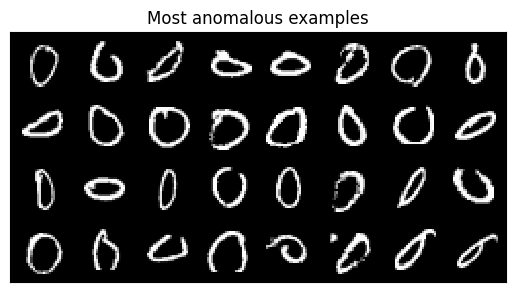

In [48]:
run(
    dataset_name="mnist",
    net_name="mnist_LeNet",
    xp_path="./results",
    data_path="./",
    load_config=None,
    load_model=None,
    gamma=0.1,
    device="cuda",
    seed=-1,
    optimizer_name="adam",
    lr=0.001,
    n_epochs=50,
    lr_milestone=0,
    batch_size=32,
    weight_decay=1e-6,
    pretrain=True,
    ae_optimizer_name="adam",
    ae_lr=0.001,
    ae_n_epochs=100,
    ae_lr_milestone=0,
    ae_batch_size=32,
    ae_weight_decay=1e-6,
    n_jobs_dataloader=0,
    normal_class=0
)

# @click.argument('dataset_name', type=click.Choice(['mnist', 'cifar10']))
# @click.argument('net_name', type=click.Choice(['mnist_LeNet', 'cifar10_LeNet', 'cifar10_LeNet_ELU']))
# @click.argument('xp_path', type=click.Path(exists=True))
# @click.argument('data_path', type=click.Path(exists=True))
# @click.option('--load_config', type=click.Path(exists=True), default=None,
#               help='Config JSON-file path (default: None).')
# @click.option('--load_model', type=click.Path(exists=True), default=None,
#               help='Model file path (default: None).')
# @click.option('--objective', type=click.Choice(['one-class', 'soft-boundary']), default='one-class',
#               help='Specify Deep SVDD objective ("one-class" or "soft-boundary").')
# @click.option('--nu', type=float, default=0.1, help='Deep SVDD hyperparameter nu (must be 0 < nu <= 1).')
# @click.option('--device', type=str, default='cuda', help='Computation device to use ("cpu", "cuda", "cuda:2", etc.).')
# @click.option('--seed', type=int, default=-1, help='Set seed. If -1, use randomization.')
# @click.option('--optimizer_name', type=click.Choice(['adam', 'amsgrad']), default='adam',
#               help='Name of the optimizer to use for Deep SVDD network training.')
# @click.option('--lr', type=float, default=0.001,
#               help='Initial learning rate for Deep SVDD network training. Default=0.001')
# @click.option('--n_epochs', type=int, default=50, help='Number of epochs to train.')
# @click.option('--lr_milestone', type=int, default=0, multiple=True,
#               help='Lr scheduler milestones at which lr is multiplied by 0.1. Can be multiple and must be increasing.')
# @click.option('--batch_size', type=int, default=128, help='Batch size for mini-batch training.')
# @click.option('--weight_decay', type=float, default=1e-6,
#               help='Weight decay (L2 penalty) hyperparameter for Deep SVDD objective.')
# @click.option('--pretrain', type=bool, default=True,
#               help='Pretrain neural network parameters via autoencoder.')
# @click.option('--ae_optimizer_name', type=click.Choice(['adam', 'amsgrad']), default='adam',
#               help='Name of the optimizer to use for autoencoder pretraining.')
# @click.option('--ae_lr', type=float, default=0.001,
#               help='Initial learning rate for autoencoder pretraining. Default=0.001')
# @click.option('--ae_n_epochs', type=int, default=100, help='Number of epochs to train autoencoder.')
# @click.option('--ae_lr_milestone', type=int, default=0, multiple=True,
#               help='Lr scheduler milestones at which lr is multiplied by 0.1. Can be multiple and must be increasing.')
# @click.option('--ae_batch_size', type=int, default=128, help='Batch size for mini-batch autoencoder training.')
# @click.option('--ae_weight_decay', type=float, default=1e-6,
#               help='Weight decay (L2 penalty) hyperparameter for autoencoder objective.')
# @click.option('--n_jobs_dataloader', type=int, default=0,
#               help='Number of workers for data loading. 0 means that the data will be loaded in the main process.')
# @click.option('--normal_class', type=int, default=0,
#               help='Specify the normal class of the dataset (all other classes are considered anomalous).')


## Testing site

In [ ]:
temp = 'dataset_name, net_name, xp_path, data_path, load_config, load_model, objective, nu, device, seed, optimizer_name, lr, n_epochs, lr_milestone, batch_size, weight_decay, pretrain, ae_optimizer_name, ae_lr, ae_n_epochs, ae_lr_milestone, ae_batch_size, ae_weight_decay, n_jobs_dataloader, normal_class'
temp = [f"{tmp}=None" for tmp in temp.split(", ")]
print(",\n".join(temp))

In [75]:
def lol(kaka=2):
  print(locals())

lol(3)

{'kaka': 3}


In [68]:
type(2) == int

True